# Exploratory Data Analysis in ARTchives - 
## Analysis of art historians' relations according to places of education and activity

### Imports

In [1]:
# rdflib
import rdflib
from rdflib import Namespace , Literal , URIRef
from rdflib.namespace import RDF , RDFS
from SPARQLWrapper import SPARQLWrapper, JSON

# utils
import ssl, os.path, json, requests , ast
from collections import defaultdict
import itertools

# spacy
import spacy
import random
from spacy.util import minibatch, compounding
from pathlib import Path
from spacy.training import Example
from spacy.tokens import Doc

# python3 -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

# data proc 
import pandas as pd
import numpy as np
from apyori import apriori

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from mlxtend.frequent_patterns import association_rules

#csv
import csv 

# graph data
import networkx as nx
from networkx.algorithms import bipartite

# data viz
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# maps
from ipywidgets import HTML
from ipyleaflet import Map, Marker, Popup, LayersControl, AwesomeIcon

#networks
from pyvis import network as net

## Utils

In [2]:
def wikidata_reconciliation(query, q_class=None):
    "Find Wikidata QID for a query string"
    params = {
        'action': 'wbsearchentities',
        'format': 'json',
        'language': 'en',
        'search': query
    }
    # query wd API
    API_WD = "https://www.wikidata.org/w/api.php"
    r = requests.get(API_WD, params = params).json()

    # double check if the entity belongs to the right class
    if 'search' in r and len(r['search']) >= 1:
        if q_class:
            query_string = """ASK {wd:"""+r['search'][0]['title']+""" a <https://www.wikidata.org/entity/"""+q_class+""">. }"""
            res = return_sparql_query_results(query_string)
            print("\nRES", query, query_string, res)
            if res["boolean"] == 'true':
                return [ r['search'][0]['title'] , 'class_match']
            else:
                return [ r['search'][0]['title'] , 'no_class_match']
        else:
            return [ r['search'][0]['title'] , 'no_class_given']
    else:
        return 'not matched'
    
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

### Get the list of historians, names, and biographies from ARTchives.

In [3]:
artists_query = """
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX wdt: <http://www.wikidata.org/wiki/Property:>
    SELECT ?historian (sample(?names) as ?name) ?bio
    WHERE { 
        ?collection wdt:P170 ?historian . 
        ?historian rdfs:label ?names. 
        OPTIONAL{?historian <http://purl.org/dc/terms/description> ?bio}
    }
    GROUP BY ?historian ?name ?bio"""

art_historians = []

try :
    art_sparql = SPARQLWrapper("http://artchives.fondazionezeri.unibo.it/sparql")
    art_sparql.setQuery(artists_query)
    art_sparql.setReturnFormat(JSON)
    results = art_sparql.query().convert()
    for result in results["results"]["bindings"]:
        historian = {}
        historian["uri"] = result["historian"]["value"]
        historian["name"] = result["name"]["value"]
        if "bio" in result:
            historian["bio"] = result["bio"]["value"]
        art_historians.append(historian)
except Exception as e:
    print(e) 
    


### Get historians' places of education and activity from Wikidata

In [4]:
ssl._create_default_https_context = ssl._create_unverified_context
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

if os.path.isfile("historian_places.json"):
    f = open('historian_places.json')
    results = json.load(f)
else:
    historians_list = ' '.join(['<'+art_dict["uri"]+'>' for art_dict in art_historians])
    eduplace_query = """ 
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    SELECT DISTINCT ?historian ?workplace ?workplace_label ?coordinates1 ?eduplace ?eduplace_label ?coordinates2
    WHERE {
            VALUES ?historian {"""+historians_list+"""} . 
            
            optional {
                ?historian wdt:P108 ?workplace . 
                ?workplace rdfs:label ?workplace_label ; 
                            wdt:P625 ?coordinates1; 
                            wdt:P31 ?type .
                FILTER (langMatches(lang(?workplace_label), "EN")) 
                ?type rdfs:label ?type_label . 
                FILTER (langMatches(lang(?type_label), "EN"))
                }
            optional {
                ?historian wdt:P69 ?eduplace . 
                ?eduplace rdfs:label ?eduplace_label ;
                            wdt:P625 ?coordinates2; 
                            wdt:P31 ?type . 
                FILTER (langMatches(lang(?eduplace_label), "EN")) 
                ?type rdfs:label ?type_label . 
                FILTER (langMatches(lang(?type_label), "EN")) 
                }
            } 
    GROUP BY ?historian ?workplace ?workplace_label ?coordinates1 ?eduplace ?eduplace_label ?coordinates2 
    """
    try :
        sparql_wd = SPARQLWrapper(wikidata_endpoint)
        sparql_wd.setQuery(eduplace_query)
        sparql_wd.setReturnFormat(JSON)
        results = sparql_wd.query().convert()

        #with open('historian_places.json', 'w') as f:
        #    json.dump(results, f, indent=4)
    except Exception as e:
        print(e)

### Include results in a graph

In [5]:
# create an empty Graph
g = rdflib.ConjunctiveGraph()

# bind namespaces
wd = Namespace("http://www.wikidata.org/entity/") # remember that a prefix matches a URI until the last slash (or hashtag #)
wdt = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")
rdfs = Namespace ("http://www.w3.org/2000/01/rdf-schema#")

for result in results["results"]["bindings"]:
    historian_uri = result["historian"]["value"]
    name = [art_dict["name"] for art_dict in art_historians if art_dict["uri"] == historian_uri][0]
    g.add(( URIRef(historian_uri) , RDFS.label , Literal(name) ))
    if "workplace" in result: 
        workplace = result["workplace"]["value"]
        if "workplace_label" in result and "coordinates1" in result: 
            workplace_label = result["workplace_label"]["value"]
            work_coord = result["coordinates1"]["value"][6:-1].split(" ")
            g.add(( URIRef(historian_uri) , URIRef(wdt.P108) , URIRef(workplace) ))
            g.add(( URIRef(workplace) , RDFS.label , Literal(workplace_label) ))
            g.add(( URIRef(workplace) , RDFS.comment , Literal("institution") ))
            g.add(( URIRef(workplace) , URIRef(wdt.P625) , Literal(work_coord) ))
    if "eduplace" in result: 
        eduplace = result["eduplace"]["value"]
        if "eduplace_label" in result and "coordinates2" in result: 
            eduplace_label = result["eduplace_label"]["value"]
            eduplace_coord = result["coordinates2"]["value"][6:-1].split(" ")
            g.add(( URIRef(historian_uri) , URIRef(wdt.P69) , URIRef(eduplace) ))
            g.add(( URIRef(eduplace) , RDFS.label , Literal(eduplace_label) ))
            g.add(( URIRef(eduplace) , RDFS.comment , Literal("institution") ))
            g.add(( URIRef(eduplace) , URIRef(wdt.P625) , Literal(eduplace_coord) ))

### Retrain Spacy to recognize specific organizations.

In [6]:
# train spacy with new data

ner=nlp.get_pipe("ner")
TRAIN_DATA = [
    ("Working at Villa I Tatti.", {"entities": [(11, 24, "ORG")]})
]

for _, annotations in TRAIN_DATA:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])
        
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

# TRAINING THE MODEL
with nlp.disable_pipes(*unaffected_pipes):

  # Training for 30 iterations
  for iteration in range(30):

    # shuufling examples  before every iteration
    random.shuffle(TRAIN_DATA)
    losses = {}
    # batch up the examples using spaCy's minibatch
    batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
    for batch in batches:
        texts, annotations = zip(*batch)
        doc = nlp.make_doc(texts[0])
        example = Example.from_dict(doc, annotations[0])
        nlp.update(
                    [example],
                    drop=0.5,  # dropout - make it harder to memorise data
                    losses=losses
                )
        print("Losses", losses)

Losses {'ner': 2.063569796214229}
Losses {'ner': 1.6189603097130236}
Losses {'ner': 0.555399093167832}
Losses {'ner': 0.005271657764780474}
Losses {'ner': 2.1379410840333235}
Losses {'ner': 0.5018046008580086}
Losses {'ner': 0.5319591538205919}
Losses {'ner': 0.0364508241895649}
Losses {'ner': 0.048372866804964776}
Losses {'ner': 0.023276400714199896}
Losses {'ner': 2.7425778245382393e-06}
Losses {'ner': 0.6850844149236792}
Losses {'ner': 0.26882229431432114}
Losses {'ner': 0.002135143471762399}
Losses {'ner': 0.0003493831394879007}
Losses {'ner': 3.507793980766129e-06}
Losses {'ner': 0.07068401482485286}
Losses {'ner': 2.052465080785496e-07}
Losses {'ner': 0.011541061195603889}
Losses {'ner': 5.8413532781011635e-06}
Losses {'ner': 1.4168560930662124e-06}
Losses {'ner': 3.0627024940344254e-07}
Losses {'ner': 1.359816013549357e-05}
Losses {'ner': 3.308586636434352e-08}
Losses {'ner': 2.014343684432679e-06}
Losses {'ner': 1.0692498379698432e-05}
Losses {'ner': 3.3238357872131556e-06}
Los

### Get places and organizations mentioned in the biographies of historians from ARTchives. Reconcile Named Entities with Wikidata.

In [7]:
artchives_places = []
for historian in art_historians:
    if "bio" in historian:
        doc = nlp(historian["bio"])
        #print('\n' , historian["name"])
        for ent in doc.ents:
            if ent.label_ == 'GPE' or ent.label_ == 'ORG':
                place = {}
                place["historian"] = historian["uri"]
                place["name"] = ent.text
                place["type"] = ent.label_
                ent_text = ent.text[4:] if (ent.text).startswith("the") else ent.text
                qid = wikidata_reconciliation(ent_text)
                place["qid"] = qid[0] if qid != 'not matched' else "not found"
                artchives_places.append(place)

Disambiguate place names that appear also in the name of the historian.

### Find coordinates in Wikidata. 

In [41]:
entities_list = []
for historian in artchives_places:
    historian["historian_name"] =  [hist["name"] for hist in art_historians if hist["uri"] == historian["historian"]][0]
    if historian["name"] not in historian["historian_name"] and historian["qid"] != 'not found':
        entities_list.append("<http://www.wikidata.org/entity/"+historian["qid"]+">")

for group_entities in chunks(entities_list, 100):
    entities_tbr = " ".join(list(set(group_entities)))  
    wd_coordinates = """
        PREFIX wdt: <http://www.wikidata.org/prop/direct/>
        SELECT DISTINCT ?place ?place_label ?coord (group_concat(?type_label ; separator="; ") as ?label) 
        WHERE {
            VALUES ?place {"""+entities_tbr+"""} . 
            ?place wdt:P625 ?coord.
            OPTIONAL {?place rdfs:label ?place_label . FILTER (langMatches(lang(?place_label), "EN")) .} 
            OPTIONAL {?place wdt:P31 ?type . ?type rdfs:label ?type_label . FILTER (langMatches(lang(?type_label), "EN"))} 
            
            } 
            group by ?place ?place_label ?coord ?label
        """

    # set the endpoint 
    sparql_wd = SPARQLWrapper(wikidata_endpoint)
    # set the query
    sparql_wd.setQuery(wd_coordinates)
    # set the returned format
    sparql_wd.setReturnFormat(JSON)
    # get the results
    results = sparql_wd.query().convert()

    loc_list = ['country', 'city', 'village', 'capital', 'state', 'region', 'municipality', 'county', 'frazione', 'comune', 'city-state', 'enclave', 'big city', 'million city']

    for result in results["results"]["bindings"]:
        loc = ''
        place = result["place"]["value"]
        place_name = result["place_label"]["value"] if "place_label" in result else "no name"
        print(place, place_name)
        coord = result["coord"]["value"][6:-1].split(" ")
        type_label = result["label"]["value"].split("; ")[0] if "label" in result else "no name"
        type_label_list = type_label.split(" ")
        check =  any(item in loc_list for item in type_label_list)
        if check:
            loc = "geolocation"
        else:
            loc = 'institution'

        g.add(( URIRef(place) , RDFS.label , Literal(place_name) ))
        g.add(( URIRef(place) , wdt.P625 , Literal(coord) ))
        g.add(( URIRef(place) , RDFS.comment , Literal(loc) ))     

http://www.wikidata.org/entity/Q90 Paris
http://www.wikidata.org/entity/Q1726 Munich
http://www.wikidata.org/entity/Q490 Milan
http://www.wikidata.org/entity/Q490 Milan
http://www.wikidata.org/entity/Q490 Milan
http://www.wikidata.org/entity/Q3757699 Galleria Spada
http://www.wikidata.org/entity/Q30 United States of America
http://www.wikidata.org/entity/Q30 United States
http://www.wikidata.org/entity/Q30 United States of America
http://www.wikidata.org/entity/Q220 Rome
http://www.wikidata.org/entity/Q65 Los Angeles
http://www.wikidata.org/entity/Q65 Los Angeles
http://www.wikidata.org/entity/Q5092 Baltimore
http://www.wikidata.org/entity/Q5092 Baltimore
http://www.wikidata.org/entity/Q5092 Baltimore
http://www.wikidata.org/entity/Q239303 Art Institute of Chicago
http://www.wikidata.org/entity/Q239303 Art Institute of Chicago
http://www.wikidata.org/entity/Q820887 University of Florence
http://www.wikidata.org/entity/Q90 Paris
http://www.wikidata.org/entity/Q731126 J. Paul Getty Museu

http://www.wikidata.org/entity/Q4012761 Poggio Reale
http://www.wikidata.org/entity/Q39 Switzerland
http://www.wikidata.org/entity/Q90 Paris
http://www.wikidata.org/entity/Q1726 Munich
http://www.wikidata.org/entity/Q490 Milan
http://www.wikidata.org/entity/Q2044 Florence
http://www.wikidata.org/entity/Q1614068 United State Schools for Fine and Applied Arts
http://www.wikidata.org/entity/Q490 Milan
http://www.wikidata.org/entity/Q490 Milan
http://www.wikidata.org/entity/Q30 United States of America
http://www.wikidata.org/entity/Q30 United States
http://www.wikidata.org/entity/Q30 United States of America
http://www.wikidata.org/entity/Q220 Rome
http://www.wikidata.org/entity/Q4191 Lucerne
http://www.wikidata.org/entity/Q49210 New York University
http://www.wikidata.org/entity/Q6602 Strasbourg
http://www.wikidata.org/entity/Q39 Switzerland
http://www.wikidata.org/entity/Q90 Paris
http://www.wikidata.org/entity/Q2093794 Vassar College
http://www.wikidata.org/entity/Q38 Italy
http://www.

### Link new places to historians

In [42]:
for historian in artchives_places:
    qid = URIRef("http://www.wikidata.org/entity/"+historian["qid"]) if historian["qid"] != 'not found' else None
    if qid and (qid, RDFS.label, None) in g:
        g.add(( URIRef(historian["historian"]) , wdt.P7153 , qid )) # P7153 significant place
        
g.serialize(destination='RQ1.nq', format='nquads') 

### Convert to JSON.

In [43]:
data_RQ1 = []

g = rdflib.ConjunctiveGraph()

# parse a local RDF file by specifying the format
result = g.parse("RQ1.nq", format='nquads')

qres = g.query(
    """
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    SELECT DISTINCT ?placeqid ?placename ?coords ?placetype ?historianuri ?historianlabel 
       WHERE {
          ?placeqid wdt:P625 ?coords .
          OPTIONAL {?placeqid rdfs:label ?placename ; rdfs:comment ?placetype .}
          ?historianuri (wdt:P7153 | wdt:P108 | wdt:P69) ?placeqid ; rdfs:label ?historianlabel
       }""")

unique_places = list(set([row[0] for row in qres]))

for place in unique_places:
    place_dict = defaultdict(list)
    for row in qres:
        if row[0] == place:
            place_dict["QID"] = str(row[0])
            place_dict["label"] = str(row[1])
            place_dict["coords"] = str(row[2])
            place_dict["type"] = str(row[3])
            place_dict["historians"]. append(( str(row[4]),str(row[5])  ))
    place_dict = dict(place_dict)
    data_RQ1.append(place_dict)

In [44]:
data_RQ1_hist = []
unique_historians = list(set(row[4] for row in qres))
for hist in unique_historians:
    hist_dict = defaultdict(list)
    for row in qres:
        if row[4] == hist:
            hist_dict["historian"] = str(row[4])
            hist_dict["label"] = str(row[5])
            loc_type = " (loc)" if str(row[3]) == "geolocation" else " (inst)"
            place = "United States (loc)" if str(row[1]) == "United States of America" else str(row[1])+loc_type
            hist_dict["places"].append(place)
    hist_dict["places"] = list(set(hist_dict["places"]))
    hist_dict = dict(hist_dict)
    data_RQ1_hist.append(hist_dict)

In [45]:
with open('RQ1.json', 'w') as f:
    json.dump(data_RQ1, f, indent=4)
with open('RQ1_hist.json', 'w') as f:
    json.dump(data_RQ1_hist, f, indent=4)

### Map of the places of art historians

In [46]:
center = (41.080684, -30.683374)
m = Map(center=center, zoom=3, close_popup_on_click=False)

if os.path.isfile("RQ1.json"):
    f = open('RQ1.json')
    data_RQ1 = json.load(f)
    

for place in data_RQ1:
    historians = [list(item) for item in set(tuple(row) for row in place["historians"])]
    names = [ hist[1] for hist in historians ]
    namelist = "; ".join(names)
    coords = ast.literal_eval(place["coords"])
    if place["type"] == "geolocation":
        icon2 = AwesomeIcon(
        name = "map-marker",
        marker_color='blue',
        icon_color='white',
        spin=False
        )
        marker = Marker(icon = icon2, location=(coords[1], coords[0]))
        m.add_layer(marker)
    else:
        icon2 = AwesomeIcon(
        name = "bank",
        marker_color='green',
        icon_color='white',
        spin=False
            )
        marker = Marker(icon = icon2, location=(coords[1], coords[0]))
        m.add_layer(marker)
    
    message = HTML()
    marker.popup = message
    message.description = ""
    message.value = "<b>" + place["label"] + "</b>" + "<br/>" + namelist

m

Map(center=[41.080684, -30.683374], close_popup_on_click=False, controls=(ZoomControl(options=['position', 'zo…

### Map of the distribution of art historians

In [47]:
df = pd.read_json("RQ1.json")
df.head()

QID                          label  \
0       http://www.wikidata.org/entity/Q55                    Netherlands   
1    http://www.wikidata.org/entity/Q49166               Williams College   
2    http://www.wikidata.org/entity/Q49210            New York University   
3       http://www.wikidata.org/entity/Q30       United States of America   
4  http://www.wikidata.org/entity/Q4859590  Barber Institute of Fine Arts   

                             coords         type  \
0          ['5.55', '52.316666666']  geolocation   
1            ['-73.205', '42.7125']  institution   
2              ['-73.995', '40.73']  institution   
3         ['-98.5795', '39.828175']  geolocation   
4  ['-1.927727777', '52.450419444']  institution   

                                          historians  
0  [[http://www.wikidata.org/entity/Q3051533, Ell...  
1  [[http://www.wikidata.org/entity/Q1712683, Jul...  
2  [[http://www.wikidata.org/entity/Q90407, Richa...  
3  [[http://www.wikidata.org/entity/Q18935222, We...  
4  [[http://www.wikidata.org/entity/Q3051533, Ell...

In [48]:
df[['long','lat']] = df['coords'].str.strip('[]').str.split(', ', expand=True)
#df['list'] = df['historians'].apply(lambda txt: ','.join(map(str, txt ) ) )
df['people'] = [ "; ".join([e[1] for e in i]) for i in df['historians'].tolist() ] 
df['count'] = df.historians.apply(len)
df['long'] = df['long'].str.replace("'",'').astype(float)
df['lat'] = df['lat'].str.replace("'",'').astype(float)
tok = 'pk.eyJ1IjoibWFyaWxlbmFkYXF1aW5vIiwiYSI6ImNpeWx6MjZ3dTAwMjkzMmpyZGR2ejVqZHoifQ.AjYdPJPgptZiqrLSrrHSxQ'
px.set_mapbox_access_token(tok)
fig = px.scatter_mapbox(df, lat="lat", lon="long", size_max=40, color="type",
    size="count", hover_data=["people"], hover_name='label', zoom=2, title='Distribution of historians')
fig.update_layout( mapbox_accesstoken=tok)
#fig.show()

### Relations between art historians based on the network of places and institutions

['Ellis Waterhouse', 'Julius S. Held; Ellis Waterhouse', 'Richard Krautheimer; Julius S. Held; Leo Steinberg; Wolfgang Lotz; Werner Cohn', 'Werner Cohn; Richard Krautheimer; Ulrich Middeldorf; Leo Steinberg; Luigi Salerno; Federico Zeri; Werner Cohn; Richard Krautheimer; Ulrich Middeldorf; Leo Steinberg; Luigi Salerno; Federico Zeri', 'Ellis Waterhouse; Ellis Waterhouse', 'Eugenio Battisti', 'Federico Zeri', 'Everett Fahy', 'Luisa Vertova; Aby Warburg; Werner Cohn', 'Ellis Waterhouse', 'Gustav Ludwig', 'Federico Zeri', 'Julian Kliemann', 'Richard Krautheimer', 'Julian Kliemann; Julian Kliemann', 'John Pope-Hennessy', 'Federico Zeri; Kornél Fabriczy', 'Roberto Longhi; Roberto Longhi', 'John Pope-Hennessy', 'Everett Fahy; Kornél Fabriczy; Ernst Steinmann; Ulrich Middeldorf; Luigi Salerno', 'Ellis Waterhouse; John Pope-Hennessy', 'Ellis Waterhouse', 'Kurt Badt; Werner Cohn; Ulrich Middeldorf; Leo Steinberg; Richard Krautheimer; Julian Kliemann', 'Julius S. Held; Julius S. Held', 'Ernst St

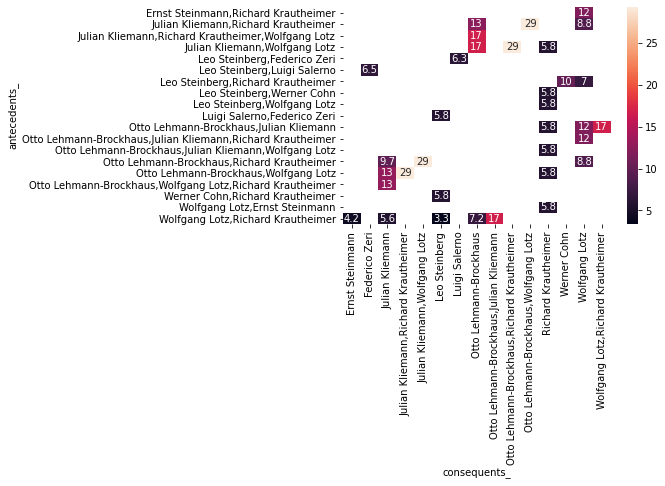

In [49]:
people = df['people'].tolist()
print(people)
people = [ list(set([el]))  if ';' not in el else list(set([i for i in el.split('; ')])) for el in people]
te = TransactionEncoder()
te_ary = te.fit(people).transform(people)
dfrel = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets_historians = fpgrowth(dfrel, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_itemsets_historians, metric="confidence", min_threshold=0.1)
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head()
# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))
# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', columns = 'consequents_', values= 'lift')
# Generate a heatmap with annotations on and the colorbar off
sns.heatmap(pivot, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

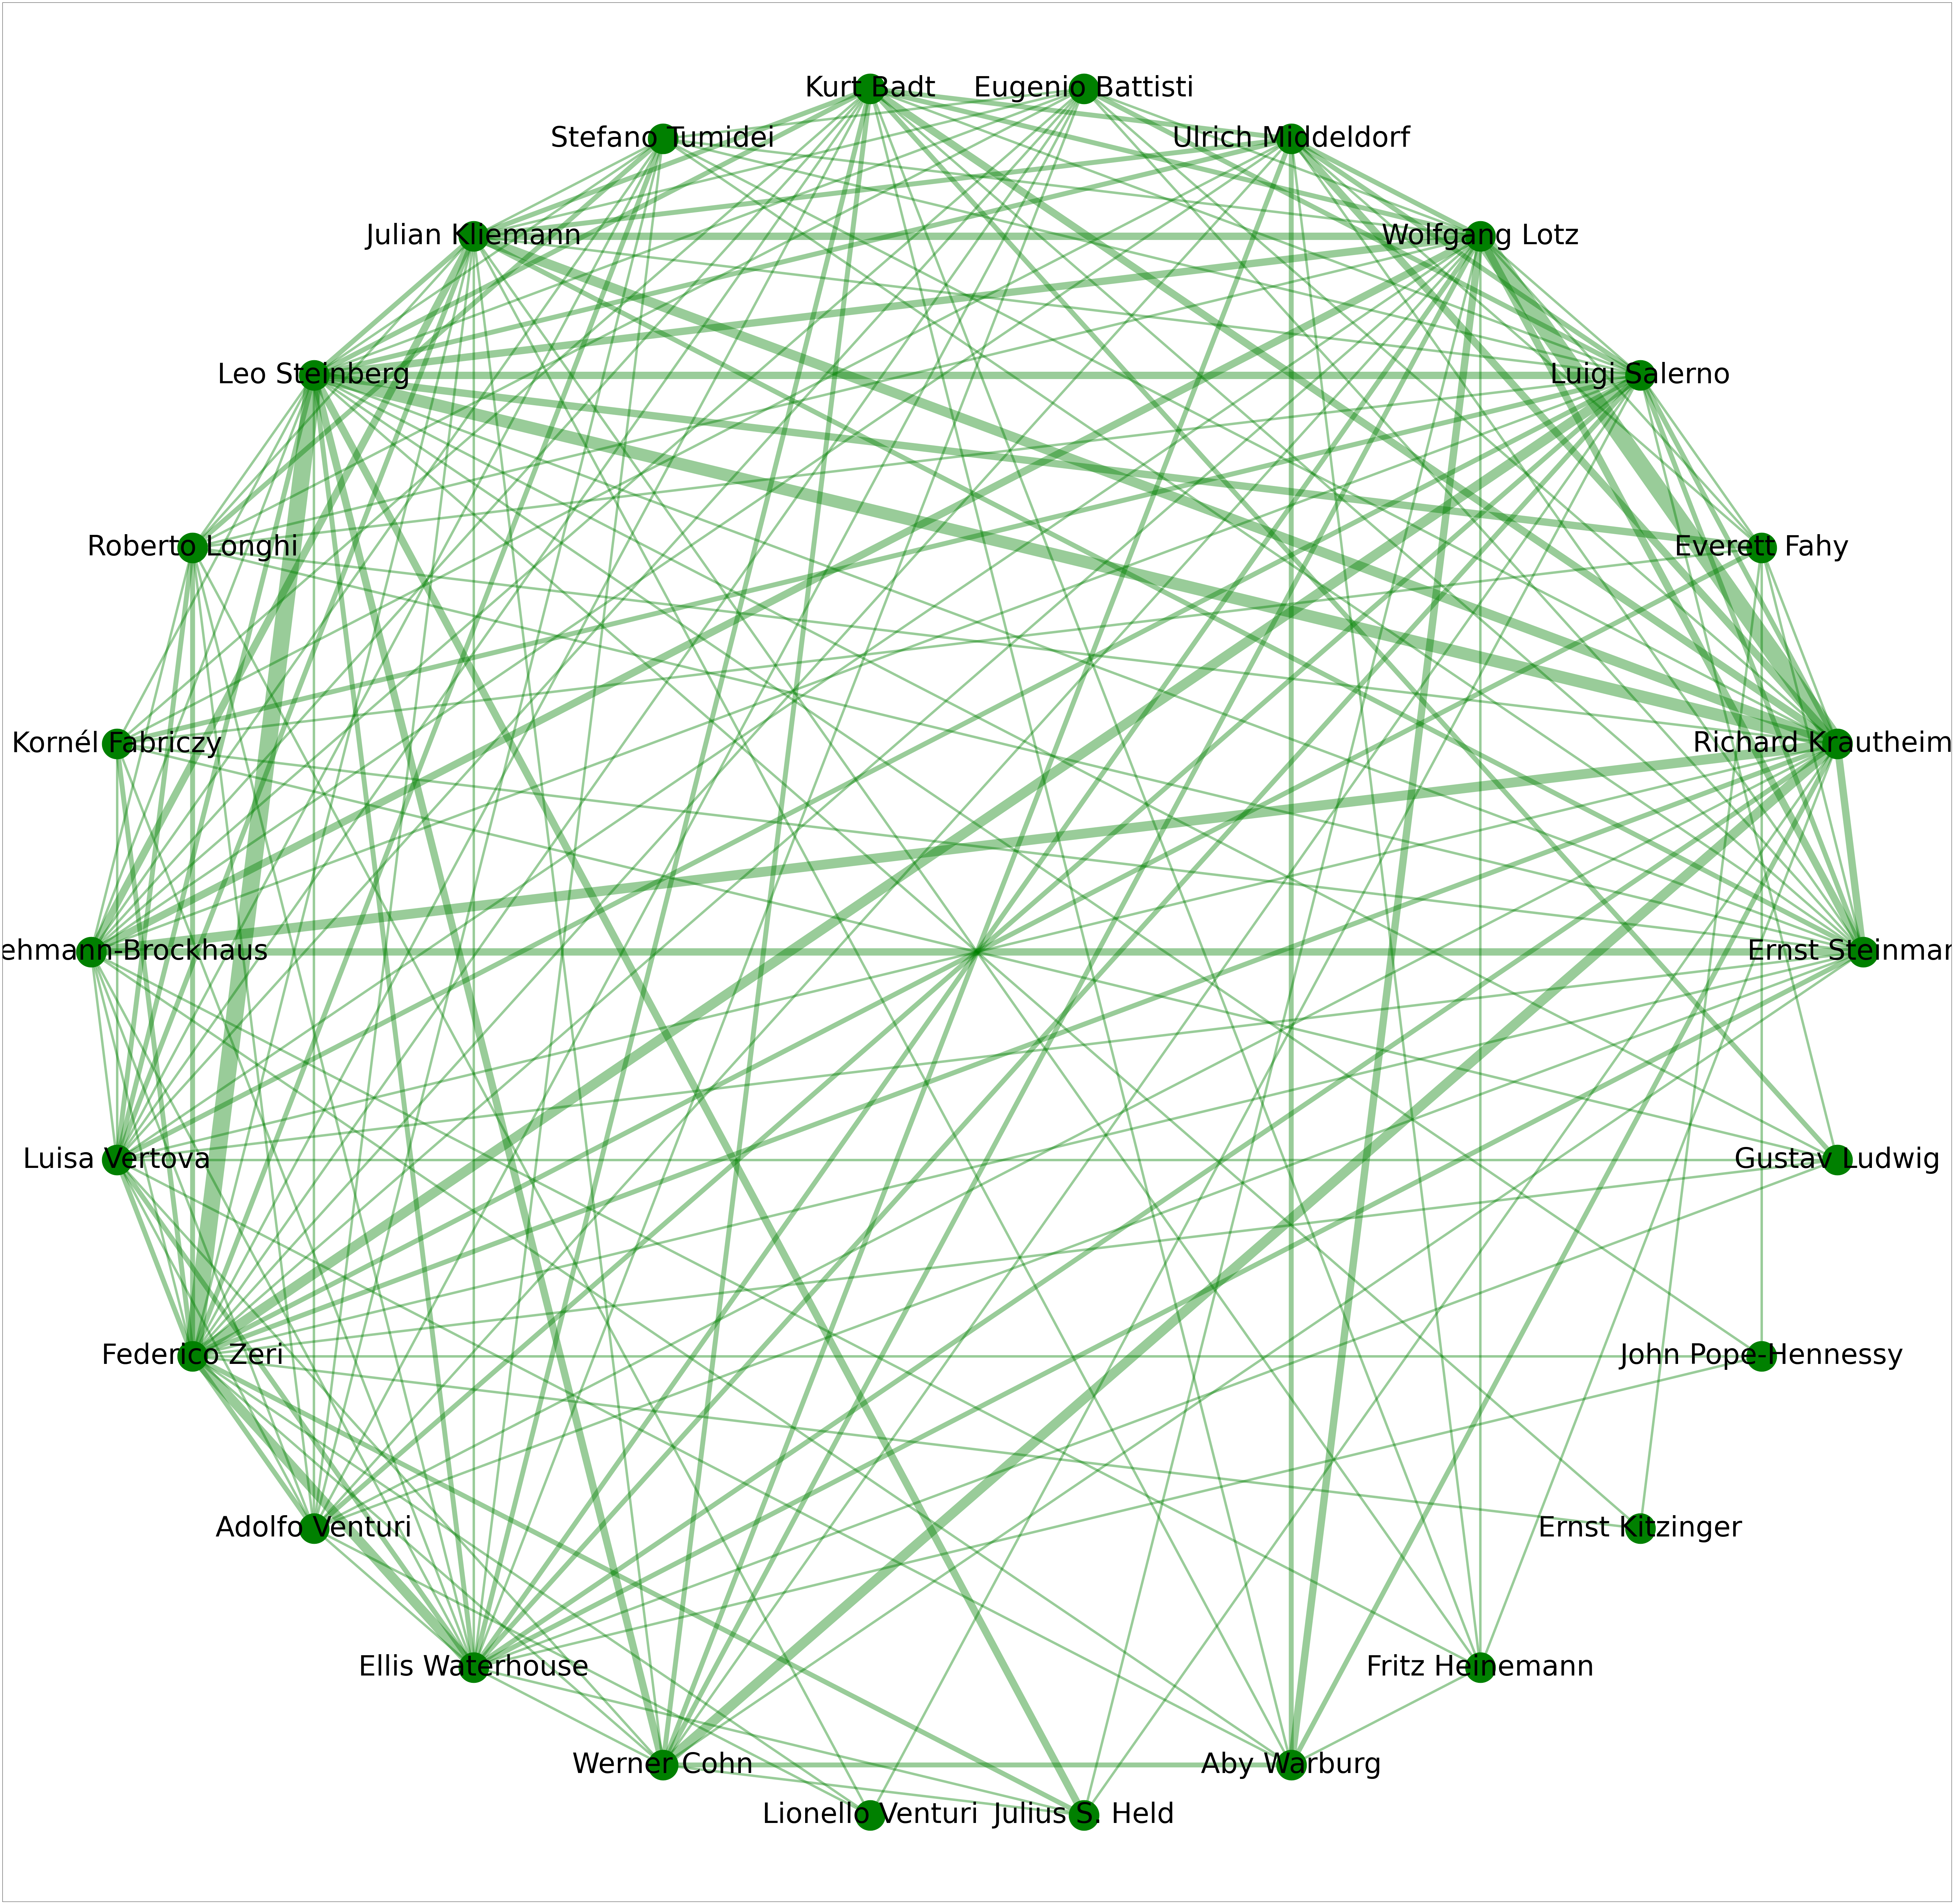

In [50]:
unique_names = set(itertools.chain.from_iterable(people))

# Get all combinations of pairs
all_pairs = list(itertools.combinations(unique_names, 2))

# Create the dictionary
hp_relations = [ (pair[0], pair[1], len([x for x in people if set(pair) <= set(x)]) ) for pair in all_pairs]
hp_relations = [ pair for pair in hp_relations if pair[2] >0]
#print(hp_relations)

G = nx.Graph()
G.add_weighted_edges_from(hp_relations)

plt.figure(1,figsize=(100,100))

pos=nx.circular_layout(G) # pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx_nodes(G,pos,node_color='green',node_size=7500)
 
#3. If you want, add labels to the nodes
labels = {}
for node_name in unique_names:
    labels[str(node_name)] = str(node_name)



nx.draw_networkx_labels(G,pos,labels,font_size=80)

all_weights = []
#4 a. Iterate through the graph nodes to gather all the weights
for (node1,node2,data) in G.edges(data=True):
    all_weights.append(data['weight']) #we'll use this when determining edge thickness

#4 b. Get unique weights
unique_weights = list(set(all_weights))

#4 c. Plot the edges - one by one!
for weight in unique_weights:
    weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
    nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,edge_color='g', width=weight*7.0, alpha= 0.4)



## Retrieval of the csv file for the annotation process

### institutions.csv

In [51]:
hi_table = []
for place in data_RQ1:
    historians = [list(item) for item in set(tuple(row) for row in place["historians"])]
    names = [ hist[1] for hist in historians ]
    if place["type"] != "geolocation":
        #print(place["label"], names)
        for el in hp_relations:
            if el[0] in names and el[1] in names:
                hi_table.append(tuple([el[0], el[1], place["label"]]))

In [52]:
with open('institutions.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['art_hist1', 'art_hist_2','institution', 'Does any relation exist between the two historians?', 'Which one? If known'])
    
    # access the list of tuples of the query results
    for res in hi_table:
        # write in the csv
        my_writer.writerow([res[0], res[1], res[2]])

In [53]:
df = pd.read_csv("institutions.csv")
df.head()

art_hist1        art_hist_2          institution  \
0       Julius S. Held  Ellis Waterhouse     Williams College   
1  Richard Krautheimer    Julius S. Held  New York University   
2  Richard Krautheimer     Wolfgang Lotz  New York University   
3  Richard Krautheimer     Leo Steinberg  New York University   
4  Richard Krautheimer       Werner Cohn  New York University   

   Does any relation exist between the two historians?  Which one? If known  
0                                                NaN                    NaN  
1                                                NaN                    NaN  
2                                                NaN                    NaN  
3                                                NaN                    NaN  
4                                                NaN                    NaN